# Selección de cripto activos para una cartera de inversión

![picture](https://drive.google.com/uc?export=view&id=1ihM3JEKP-XPaoX9b5bwymu_IF4ntTlz-)

# Trabajo Práctico 2 -  Análisis y Curación

## Introducción


A lo largo de este práctico continuaremos con la exploración del dataset iniciada en el práctio anterior, donde notamos algunas características propias de las series temporales. 
Además, vimos que no se trata de series estacionarias y en nuestro caso no apreciamos patrones de estacionalidad para la serie de tiempo de los precios.

En la siguiente notebook, se presentan las actividades relacionadas a Análisis y Curación. Buscamos identificar e implementar los pasos necesarios para la limpieza de la base de datos, así como también analizar cruces de datos con mayor profundidad. Para esto, los invito a chequear la siguiente [lista](https://dimewiki.worldbank.org/Checklist:_Data_Cleaning), donde se muestran una serie de puntos a tener en cuenta a la hora de tratar nuestros datos.

# 📖 ¡Actividades! 


Recuerden que la ciencia de datos es un proceso no lineal y continuo, es decir, si los datos requieren de mayor procesamiento para satisfacer las necesidades de algoritmos de machine learning, vamos a volver a la etapa inicial para, por ejemplo, crear nuevas features, tomar decisiones diferentes sobre valores faltantes o valores atípicos (outliers), descartar features, entre otras. ¡Manos a la obra!

Recomendación: Traten de crear funciones de manera de automatizar la mayor cantidad de pasos posibles. 

## Parte I 

- En el práctico anterior trabajamos con un conjunto de datos preprocesados, los invito a inspeccionar el siguiente conjunto de datos (link). Como pueden ver, el sistema que define las fechas no es el mismo que trabajamos durante el práctico anterior, en este caso las fechas se encuetran en tiempo Unix. Investiguen este sistema y convierta las fechas a tipo datetime. 
Para mayor información pueden ver:
    
    - [Convertir Epoch a Datetime en Python](https://www.delftstack.com/es/howto/python/python-convert-epoch-to-datetime/)


- Indaguen sobre la existencia de valores faltantes. Diferencien entre datos perdidos e inexistentes. Seleccionen un activo y visualicen utilizando la librería Missingno ¿Si uno de los precios falta, también faltan los datos en las demás columnas? ¿Cuál creen que sería la mejor forma de tratarlos? ¿Por qué? Analicen formas de imputarlos, por ejemplo, 

    - reemplazar el faltante con el valor de la media/mediana,
    - utilizar regresión. 
    - métodos backward/forward fill. 
    - Splines, etc. 
    
Para mayor información puede ver el siguiente link [Imputación](https://rpubs.com/wilsonsr/804544)

**Para discutir:** ¿Cuáles podrían ser las razones de la falta de datos, si es que esto ocurre?


- ¿Hay índices repetidos? Resuelvan. 


- Para aprovechar en mayor medida los datos disponibles, analicen dividir los datos en dos posibles conjuntos de acuerdo a la disponibilidad de información según fechas.


- ¿Podría mejorarse la forma en la que está presentada la información? Recuerden que serán necesarios todos los precios de los activos para el cálculo de features. 


- Seleccionen un activo (y alguna de las columnas referidos a precios) y confeccionen un diagrama de dispersión entre el mismo y su valor retardado un período. Repita el mismo procedimiento con sus valores retardado 2, 3 y 4 períodos. 


- Grafiquen e interpreten las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF), para el precio del activo elegido en el punto anterior. El siguiente [link](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/) puede ser útil para introducirlos en el tema.


## Parte II 

En esta instancia trabajaremos con algunos features extras que iremos generando a partir de los precios disponibles. Para ello los invito a investigar [talib](http://mrjbq7.github.io/ta-lib/doc_index.html), una de las librerías de python para análisis técnico.

- Agreguen la serie de tasas de rendimientos de cada activo. 


- Calculen las medias móviles de los precios tomando n periodos hacia atrás (n a elección).  


- ¿Conocen algunos indicadores técnicos? Entre los más conocidos podemos mencionar: [RSI](https://admiralmarkets.com/es/education/articles/forex-indicators/como-sacar-beneficio-del-indicador-de-trading-rsi), [MADC](https://admiralmarkets.com/es/education/articles/forex-indicators/macd), [ADX](https://economipedia.com/definiciones/indicador-adx-average-directional-index.html), etc... Pueden construirlos o calcularlos a partir de la librería.


- Si por ejemplo, una característica tiene una varianza de un orden de magnitud mayor que la de las otras características, podría dominar la función objetivo y hacer que el estimador no pueda aprender de otras características correctamente como se esperaba. Para lograr esto se debe llevar a cabo un escalado o normalizado de datos. ¿Cuál es la diferencia?

## Opcional

- Para alguno/s de los activos, detecten las correlaciones entre los features generados utilizando la función Heatmap().




**¡Recuerde!** 

Nunca Modificar los Datos Crudos u Originales Al finalizar la limpieza, deberán guardar el dataset resultante, para asegurarse de no modificar los datos originales.

# Fecha de entrega

- __Versión preliminar: 17/6__ 

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

In [1]:
import pandas as pd
import numpy as np

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from pylab import rcParams
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import os
import time
import missingno as msno

import talib as ta

import warnings
warnings.filterwarnings("ignore") 

Importamos la funcion "create_dataframe" que creamos en el primer práctico para poder leer todos los archivos e unirlos en un solo dataframe

In [2]:
def create_dataFrame(path):
    df = pd.DataFrame()
    files_list = os.listdir(path)
    for file in files_list:
        file_path = path + '/' + file
        if os.path.isfile(file_path):
            if df.empty:
                df = active_name(file_path, file)
            else:
                df = pd.concat([df, active_name(file_path, file)], axis = 0)
    return df     

def active_name(file, name):
    try:
        df = pd.read_csv(file)
        df.loc[:, 'active'] = name[:-4]
        return df
    except:
        print('Error en %s'% file)

# Parte I

En este caso leemos los archivos de la carpeta raw_data, para simular que recibimos los archivos directamente desde la fuente, y asi poder transformar el índice que se encuentra en formato Unix en datetime.

In [3]:
df_all = create_dataFrame('../raw_data/')
df_all.shape, df_all.head(10)

((116390, 7),
            unix    open    high     low   close     volume    active
 0  1.602731e+12  51.430  59.000  46.158  49.031  25203.494  AAVEUSDT
 1  1.602745e+12  49.150  49.446  44.514  44.668  19997.896  AAVEUSDT
 2  1.602760e+12  44.629  48.482  44.392  47.000  22164.784  AAVEUSDT
 3  1.602774e+12  47.201  48.017  45.889  46.976   8229.208  AAVEUSDT
 4  1.602788e+12  46.976  47.997  45.673  45.800   7019.526  AAVEUSDT
 5  1.602803e+12  45.801  45.891  42.000  43.719  38813.044  AAVEUSDT
 6  1.602817e+12  43.707  43.707  40.649  41.426  20515.319  AAVEUSDT
 7  1.602832e+12  41.450  42.792  39.911  41.556  20748.984  AAVEUSDT
 8  1.602846e+12  41.474  42.256  40.837  41.743   9247.422  AAVEUSDT
 9  1.602860e+12  41.721  41.830  40.370  40.873   6514.351  AAVEUSDT)

set(df_all.active)Verificamos la lista de activos que cargamos en el dataframe unico.

In [4]:
set(df_all.active)

{'AAVEUSDT',
 'ADAUSDT',
 'AXSUSDT',
 'BCHUSDT',
 'BNBUSDT',
 'BTCUSDT',
 'COMPUSDT',
 'DASHUSDT',
 'DOGEUSDT',
 'DOTUSDT',
 'EOSUSDT',
 'ETCUSDT',
 'ETHUSDT',
 'LINKUSDT',
 'LTCUSDT',
 'LUNAUSDT',
 'NEOUSDT',
 'XMRUSDT',
 'XRPUSDT'}

Para transformar el índice en formato datetime, utilizaremos la función to_datetime que pertenece a Pandas, y permite ingresar la fecha en formato de milisegundos de Unix y poder transformarlo a un lenguaje más legible.

In [5]:
df_all['unix'] = pd.to_datetime(df_all['unix'],unit='ms')
df_all.rename(columns={'unix':'Fecha'},inplace=True)
df_all.set_index('Fecha', inplace = True)
df_all.sort_values(by=['Fecha'],ascending=False)

,open,high,low,close,volume,active
Fecha,,,,,,
2022-05-05 15:00:00,0.6170,NaN,NaN,NaN,NaN,XRPUSDT
2022-05-05 15:00:00,31.4300,NaN,NaN,NaN,NaN,AXSUSDT
2022-05-05 15:00:00,11.4000,NaN,NaN,NaN,NaN,LINKUSDT
2022-05-05 15:00:00,29.7900,NaN,NaN,NaN,NaN,ETCUSDT
2022-05-05 15:00:00,215.1000,NaN,NaN,NaN,NaN,XMRUSDT
...,...,...,...,...,...,...
2019-01-01 03:00:00,7.3740,7.43000,7.35200,7.40900,39067.819,NEOUSDT
2019-01-01 03:00:00,4.9419,5.11270,4.93790,5.04560,45501.840,ETCUSDT
2019-01-01 03:00:00,2.5206,2.56000,2.52040,2.53830,474419.580,EOSUSDT


Vamos a agregar al dataframe las columnas de dia, mes, año, dia de la semana, profit y volumen real, para facilitar su análisis posteriormente.

In [6]:
df_all['day'] = df_all.index.day
df_all['month'] = df_all.index.month
df_all['year'] = df_all.index.year
df_all['weekday'] = df_all.index.day_name()
df_all['profit'] = 100*(df_all['close'] - df_all['open']) / df_all['open']
df_all.head(10)

,open,high,low,close,volume,active,day,month,year,weekday,profit
Fecha,,,,,,,,,,,
2020-10-15 03:00:00,51.430,59.000,46.158,49.031,25203.494,AAVEUSDT,15,10,2020,Thursday,-4.664593
2020-10-15 07:00:00,49.150,49.446,44.514,44.668,19997.896,AAVEUSDT,15,10,2020,Thursday,-9.119023
2020-10-15 11:00:00,44.629,48.482,44.392,47.000,22164.784,AAVEUSDT,15,10,2020,Thursday,5.312689
2020-10-15 15:00:00,47.201,48.017,45.889,46.976,8229.208,AAVEUSDT,15,10,2020,Thursday,-0.476685
2020-10-15 19:00:00,46.976,47.997,45.673,45.800,7019.526,AAVEUSDT,15,10,2020,Thursday,-2.503406
2020-10-15 23:00:00,45.801,45.891,42.000,43.719,38813.044,AAVEUSDT,15,10,2020,Thursday,-4.545752
2020-10-16 03:00:00,43.707,43.707,40.649,41.426,20515.319,AAVEUSDT,16,10,2020,Friday,-5.218844
2020-10-16 07:00:00,41.450,42.792,39.911,41.556,20748.984,AAVEUSDT,16,10,2020,Friday,0.255730
2020-10-16 11:00:00,41.474,42.256,40.837,41.743,9247.422,AAVEUSDT,16,10,2020,Friday,0.648599


Creamos la funcion "status" que recibe como parámetro un dataframe y permite identificar facilmente la cantidad de filas, los valores faltantes por fila, la cantidad de ceros, valores únicos y los tipos de datos

In [7]:
def status(data):

    data2=data 
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    
    return(d2)

In [8]:
status(df_all)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,open,0,0.000000,0,0.000000,82819,float64
1,high,274,0.002354,0,0.000000,77285,float64
2,low,274,0.002354,0,0.000000,77364,float64
3,close,274,0.002354,0,0.000000,82547,float64
4,volume,274,0.002354,0,0.000000,116113,float64
5,active,0,0.000000,0,0.000000,19,object
6,day,0,0.000000,0,0.000000,31,int64
7,month,0,0.000000,0,0.000000,12,int64
8,year,0,0.000000,0,0.000000,4,int64
9,weekday,0,0.000000,0,0.000000,7,object


Como resultado vemos que las columnas high, low, close, volume, profit y real_volume tienen valores faltantes, pero en relacion a la cantidad de datos el porcentaje es muy bajo. Consideramos que es importante completar estas filas de datos faltantes utilizando alguna función de imputación, ya que al ser series temporales, es importante tener los datos completos.

In [9]:
for cripto in set(df_all.active):
    print("La moneda {} tiene valores entre {} y {}".format(cripto, df_all[df_all.active == cripto].index.min(), df_all[df_all.active == cripto].index.max()))

La moneda LTCUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda XRPUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda DASHUSDT tiene valores entre 2019-03-28 07:00:00 y 2022-05-05 15:00:00
La moneda BTCUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda NEOUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda ETHUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda ADAUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda AAVEUSDT tiene valores entre 2020-10-15 03:00:00 y 2022-05-05 15:00:00
La moneda DOTUSDT tiene valores entre 2020-08-18 23:00:00 y 2022-05-05 15:00:00
La moneda BCHUSDT tiene valores entre 2019-11-28 11:00:00 y 2022-05-05 15:00:00
La moneda EOSUSDT tiene valores entre 2019-01-01 03:00:00 y 2022-05-05 15:00:00
La moneda LUNAUSDT tiene valores entre 2020-08-21 11:00:00 y 2022-05-05 15:00:00
La moneda ETCUSDT tiene valores entre

Aqui podemos ver un poco mejor el período de análisis de cada activo, y vemos que no todos empiezan desde la misma fecha, por lo que luego hay que analizar que período considerar para que sea uniforme para todos los activos.

# Outliers

Definimos la funcion "quantil" que devuelve los cuantiles 25 y 75 de la columna analizada. Vamos a utilizar la técnica de cuantiles para poder identificar posibles outliers en los datos, y luego analizaremos que hacer con ellos.

In [10]:
def quantil(x):
    return x.quantile(0.25)[0], x.quantile(0.75)[0]

In [11]:
for cripto in set(df_all.active):
    aux = df_all[df_all.active == cripto]
    close = aux[['close']]
    q1,q3 = quantil(close)
    lim1 = q1 - 1.5*(q3-q1)
    lim2 = q3 + 1.5*(q3-q1)
    outliers = len(aux[aux.close < lim1]) + len(aux[aux.close > lim2])
    if aux.index.has_duplicates:
        print('El activo {} tiene índices repetidos, y tiene {} outliers de un total de {}.'.format(cripto, outliers, len(aux)))
    else:
        print('El activo {} NO tiene índices repetidos, y tiene {} outliers de un total de {}.'.format(cripto, outliers, len(aux)))

El activo LTCUSDT NO tiene índices repetidos, y tiene 94 outliers de un total de 7307.
El activo XRPUSDT NO tiene índices repetidos, y tiene 109 outliers de un total de 7307.
El activo DASHUSDT NO tiene índices repetidos, y tiene 235 outliers de un total de 6792.
El activo BTCUSDT NO tiene índices repetidos, y tiene 0 outliers de un total de 7307.
El activo NEOUSDT NO tiene índices repetidos, y tiene 389 outliers de un total de 7307.
El activo ETHUSDT NO tiene índices repetidos, y tiene 0 outliers de un total de 7307.
El activo ADAUSDT NO tiene índices repetidos, y tiene 25 outliers de un total de 7307.
El activo AAVEUSDT NO tiene índices repetidos, y tiene 1 outliers de un total de 3401.
El activo DOTUSDT NO tiene índices repetidos, y tiene 0 outliers de un total de 3744.
El activo BCHUSDT NO tiene índices repetidos, y tiene 127 outliers de un total de 5328.
El activo EOSUSDT NO tiene índices repetidos, y tiene 221 outliers de un total de 7307.
El activo LUNAUSDT NO tiene índices repe

Vemos que la cantidad de outliers no es significativa, y sabemos que la volatilidad de las criptomonedas es muy alta, por lo que no consideramos que estos valores sean realmente outliers, sino que los precios de estos activos fluctuan entre rangos de valores muy altos y es su normalidad.

In [12]:
df_all['real_volume'] = df_all['volume'] * df_all['close']

Armamos un dataframe con el volumen promedio de cada moneda expresado en USD, para luego poder hacer un filtro de las monedas más operadas.

In [13]:
df_volume = pd.DataFrame(columns=['active','volume_mean','porcentaje'])
i = 0
for active in set(df_all.active):
    df_volume.loc[i, 'volume_mean'] = df_all[df_all.active == active]['real_volume'].mean()
    df_volume.loc[i, 'active'] = active
    df_volume.loc[i, 'porcentaje'] = (df_all[df_all.active == active]['real_volume'].sum() / df_all['real_volume'].sum()) * 100
    i += 1

df_volume.sort_values(by='volume_mean', ascending=False).reset_index(drop=True)

,active,volume_mean,porcentaje
0,BTCUSDT,2.44886e+08,34.3898
1,ETHUSDT,1.4636e+08,20.5537
2,DOGEUSDT,5.79631e+07,6.90381
3,BNBUSDT,5.62242e+07,7.89567
4,DOTUSDT,4.89143e+07,3.52031
5,XRPUSDT,4.60011e+07,6.46002
6,ADAUSDT,3.47929e+07,4.88603
7,LUNAUSDT,3.08048e+07,2.20809
8,AXSUSDT,1.8325e+07,1.15433
9,LINKUSDT,1.73169e+07,2.40115


In [14]:
df_volume.porcentaje.sum()

100.0

Vemos que las 5 monedas con mayor volumen son BTC, ETH, DOGE, BNB y DOT. Los análisis que realicemos de ahora en adelante los haremos sobre estas 5 monedas para facilitar su comprensión, y para eso, generamos un nuevo dataframe con el resultado del filtro.

In [15]:
top_volume = list(df_volume.sort_values(by='volume_mean', ascending = False)['active'].head(5))
df_filtered = df_all[df_all.active.isin(top_volume)]
df_filtered.shape

(31864, 12)

De las 5 cripto con mayor volumen, tomamos DOGE para evaluar la cantidad de datos faltantes

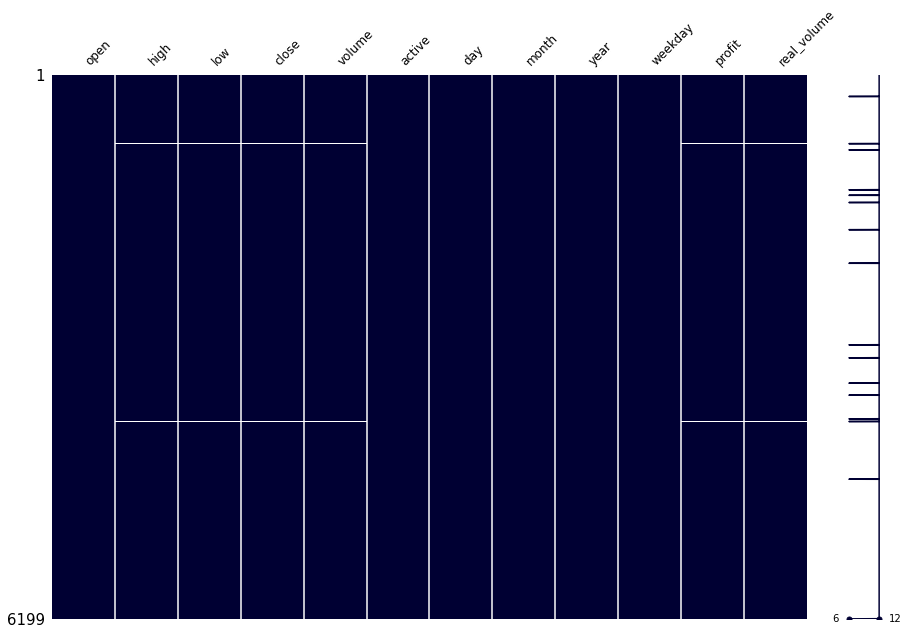

In [16]:
msno.matrix(df_filtered[df_filtered.active == 'DOGEUSDT'], figsize=(15, 10), fontsize=12, color=[0,0,0.2])

In [17]:
aux = df_all[df_all.active == 'DOGEUSDT']
close = aux[['close']]
q1,q3 = quantil(close)
lim1 = q1 - 1.5*(q3-q1)
lim2 = q3 + 1.5*(q3-q1)
outliers = len(aux[aux.close < lim1]) + len(aux[aux.close > lim2])
print('Para la cripto {} hay {} valores nulos de un total de {}, representa un {}% del total.'.format('DOGEUSDT', aux.isna().sum().sum(), len(aux), round((aux.isna().sum().sum()/len(aux))*100)))

Para la cripto DOGEUSDT hay 96 valores nulos de un total de 6199, representa un 2.0% del total.


Una vez analizado los valores faltante y su comportamiento, decidimos eliminar las ultimas filas ya que su representacion se debe a que para el momento que se tomaron los datos, el periodo de tiempo de las 4 horas no habia terminado.

Tambien dado que la cantidad de datos faltantes es muy baja para todos los activos, asi como tambíen debido a que los datos faltantes en todos los casos aparecen aislados (una unica fila faltante rodeada por filas con datos completos), hemos decidido aplicar un método de imputación sencillo en el que a la fila de datos faltantes le asignamos los valores de una fila contigua. Optamos por el método Backwardfill, utilizando para la imputación los valores de la fila siguiente. 

In [18]:
#Función para eliminar la última fila de cada activo porque está vacía
def drop_lr (dataframe):
    for active in set(dataframe.active): 
        mask =  dataframe['active'] == active
        index_i = dataframe[mask].tail(1).index
        dataframe.drop(index = index_i, inplace=True)
    return (dataframe)

df_all = drop_lr(df_all) #Eliminamos la última fila de datos de cada activo porque en todos los casos solo cuenta con el valor de "Open" y falta el resto de valores . 

In [19]:
#Función para imputar valores faltantes mediante un Backward fill 
def imput (dataframe):
    for active in set(dataframe.active): 
        mask =  dataframe['active'] == active
        dataframe[mask]=dataframe[mask].bfill(axis='rows', inplace=False, limit=None, downcast=None)
    return (dataframe)

df_all = imput(df_all) #imputamos los valores faltantes 

In [20]:
status(df_all)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,open,0,0.0,0,0.000000,82723,float64
1,high,0,0.0,0,0.000000,77211,float64
2,low,0,0.0,0,0.000000,77289,float64
3,close,0,0.0,0,0.000000,82461,float64
4,volume,0,0.0,0,0.000000,115771,float64
5,active,0,0.0,0,0.000000,19,object
6,day,0,0.0,0,0.000000,31,int64
7,month,0,0.0,0,0.000000,12,int64
8,year,0,0.0,0,0.000000,4,int64
9,weekday,0,0.0,0,0.000000,7,object


# Parte II

En esta instancia trabajaremos con algunos features extras que iremos generando a partir de los precios disponibles. Para ello los invito a investigar talib, una de las librerías de python para análisis técnico.

Agreguen la serie de tasas de rendimientos de cada activo.
Calculen las medias móviles de los precios tomando n periodos hacia atrás (n a elección).
¿Conocen algunos indicadores técnicos? Entre los más conocidos podemos mencionar: RSI, MADC, ADX, etc... Pueden construirlos o calcularlos a partir de la librería.
Si por ejemplo, una característica tiene una varianza de un orden de magnitud mayor que la de las otras características, podría dominar la función objetivo y hacer que el estimador no pueda aprender de otras características correctamente como se esperaba. Para lograr esto se debe llevar a cabo un escalado o normalizado de datos. ¿Cuál es la diferencia?

Antes de calcular features, tenemos que imputar los valores faltantes ya que sino la librería no va a poder hacer los cálculos necesarios. Utilizaremos ffill para imputar los nulos, y en la misma iteración calcularemos los indicadores técnicos para usar posteriormente.

In [21]:
contador = 0
for i in set(df_all.active):
    aux = df_all[df_all.active == i]
    aux = aux.fillna(method='ffill')
    aux['EMA200'] = ta.EMA(aux['close'],200)
    aux['EMA100'] = ta.EMA(aux['close'],100)
    aux['EMA50'] = ta.EMA(aux['close'],50)
    aux['EMA20'] = ta.EMA(aux['close'],20)
    aux['RSI200'] = ta.RSI(aux['close'],200)
    aux['ADX200'] = ta.ADX(aux['high'], aux['low'], aux['close'],200)
    aux['MACD'] = ta.MACD(aux['close'], fastperiod=12, slowperiod=26, signalperiod=9)[0]
    if contador == 0:
        df_final = aux.copy()
        contador += 1
    else:
        df_final = pd.concat([df_final, aux])
        
df_final

,open,high,low,close,volume,active,day,month,year,weekday,profit,real_volume,EMA200,EMA100,EMA50,EMA20,RSI200,ADX200,MACD
Fecha,,,,,,,,,,,,,,,,,,,
2019-01-01 03:00:00,29.73,30.16,29.57,30.12,10344.49821,LTCUSDT,1,1,2019,Tuesday,1.311806,3.115763e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 07:00:00,30.14,30.67,30.13,30.34,8793.09194,LTCUSDT,1,1,2019,Tuesday,0.663570,2.667824e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 11:00:00,30.35,30.79,30.24,30.29,20755.11106,LTCUSDT,1,1,2019,Tuesday,-0.197694,6.286723e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 15:00:00,30.30,30.50,29.84,29.92,12025.85232,LTCUSDT,1,1,2019,Tuesday,-1.254125,3.598135e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 19:00:00,29.91,31.62,29.87,31.10,36093.69359,LTCUSDT,1,1,2019,Tuesday,3.978602,1.122514e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01 19:00:00,103.70,105.90,102.30,104.40,5959.18000,COMPUSDT,1,5,2022,Sunday,0.675024,6.221384e+05,130.264364,126.708558,119.791947,111.152194,46.487948,6.541840,-5.791209
2022-05-01 23:00:00,104.40,107.30,104.00,105.70,6205.63200,COMPUSDT,1,5,2022,Sunday,1.245211,6.559353e+05,130.019942,126.292547,119.239322,110.632938,46.652596,6.540635,-5.511763
2022-05-02 03:00:00,105.70,107.90,105.30,106.90,3165.45900,COMPUSDT,2,5,2022,Monday,1.135289,3.383876e+05,129.789893,125.908536,118.755427,110.277420,46.804439,6.538620,-5.134286


Recorro todo el dataframe y me quedo con el minimo de cada indice para ir armando una lista con la primer fecha que aparece en cada activo. Luego de esa lista, me quedo con el valor máximo, que va a coincidir con todos los activos y va a ser nuestro punto de partida para partir de ahi con todos los activos.

In [22]:
contador = 0
minimos = []
for i in set(df_final.active):
    aux = df_final[df_final.active == i]
    min_aux = aux.index.min()
    minimos.append(min_aux)

max_total = minimos[np.argmax(np.asarray(minimos))]
max_total

Timestamp('2020-11-04 15:00:00')

In [23]:
minimos.sort()

In [24]:
minimos

[Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-01 03:00:00'),
 Timestamp('2019-01-16 11:00:00'),
 Timestamp('2019-03-15 07:00:00'),
 Timestamp('2019-03-28 07:00:00'),
 Timestamp('2019-07-05 15:00:00'),
 Timestamp('2019-11-28 11:00:00'),
 Timestamp('2020-06-25 07:00:00'),
 Timestamp('2020-08-18 23:00:00'),
 Timestamp('2020-08-21 11:00:00'),
 Timestamp('2020-10-15 03:00:00'),
 Timestamp('2020-11-04 15:00:00')]

Recorro nuevamente el dataframe pero ahora hago un slice a partir de la fecha que obtuve en la celda anterior.

In [25]:
contador = 0

for i in set(df_final.active):
    aux = df_final[df_final.active == i]
    aux_1 = aux[max_total:]
    if contador == 0:
        df_final_max = aux_1.copy()
        contador += 1
    else:
        df_final_max = pd.concat([df_final_max, aux_1])    

df_final_max.shape

(61921, 19)

In [26]:
df_final.shape

(116029, 19)

Analizando la cantidad de datos con la que nos quedamos luego de hacer el slice, vemos que perdemos más de la mitad de los datos haciendo este recorte (de 116390 registros pasamos a 62282, por lo tanto es un 53%). Consideramos que la pérdida de datos es muy grande, por lo tanto vamos a dejar los datos como los tenemos. Posteriormente podemos agrupar los datos entre los activos que tienen los datos completos desde 2019 y luego los activos que varían entre fines de 2019 y principios de 2020.

Realizamos analisis de dispersion para el bitcoin,como ya vimos es la criptomoneda con mayor volumen,para evaluar su comportamiento referente a diferentes periodos y frecuencias.

In [27]:
#Función para realizar diagramas de dispersión entre un precio y el mismo retrasado n periodos
def disp_ret_graph (df, active, freq):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,12));

    ax11 = axes[0][0]
    ax12 = axes[0][1]
    ax21 = axes[0][2]
    ax22 = axes[1][0]
    ax31 = axes[1][1]
    ax32 = axes[1][2]
    
    axe = [ax11, ax12, ax21, ax22, ax31, ax32]

    mask = df['active'] == active
    
    df_aux = df[mask].asfreq(freq)

    start = 1
    end = len(df_aux)


    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    i = 0
    for ax in axe:
        ax.scatter(x = df_aux.open.iloc[0+i:end], y = df_aux.open.iloc[0:end-i], s=1)
        ax.set_xlabel('Precio High')
        ax.set_ylabel('Precio High -' + str(i) + ' periodo')
        ax.title.set_text('Precio High vs Precio High -' + str(i) + ' periodo')
        i = i+1

    return

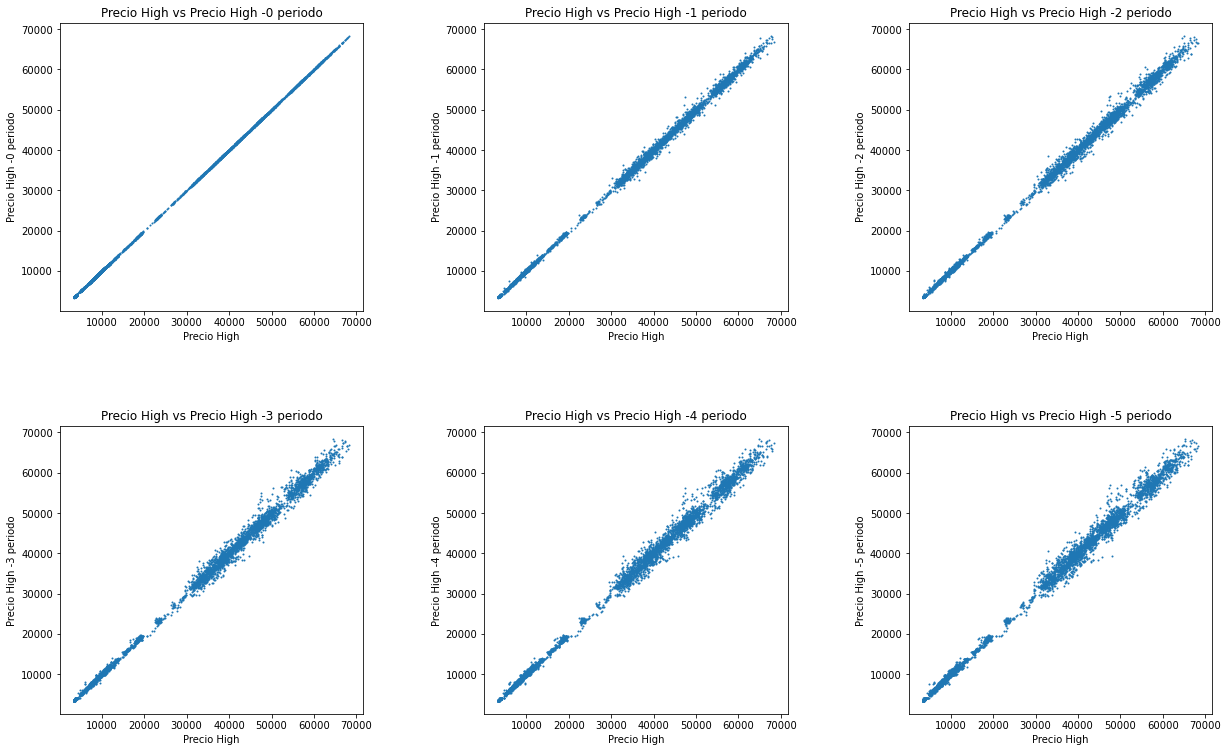

In [28]:
# Primero vemos con frecuencia de 4 horas
#gráfico de dispersión de precio open para el activo seleccionado y la frecuencia deseada (4H,8H,12H,16H, 20H, D, W o M)
disp_ret_graph (df_all, active = "BTCUSDT", freq ='4H') 

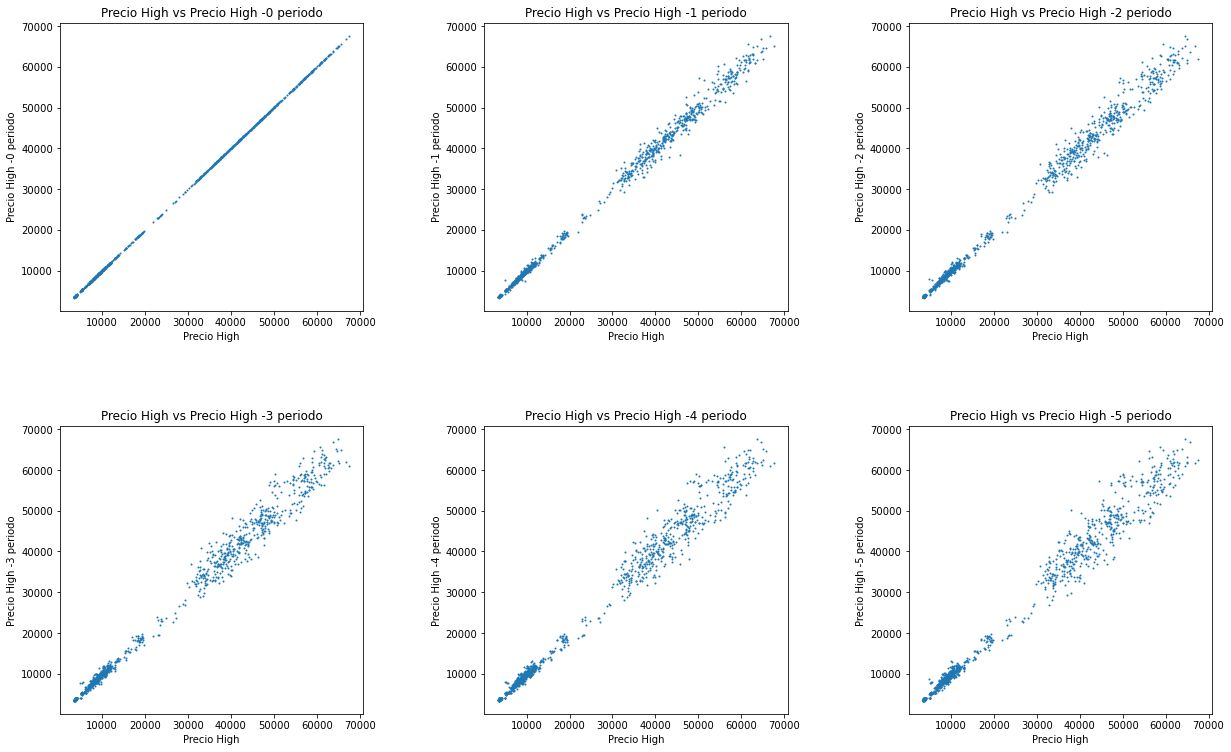

In [29]:
# Frecuencia diaria
disp_ret_graph (df_all, active = "BTCUSDT", freq ='D')  

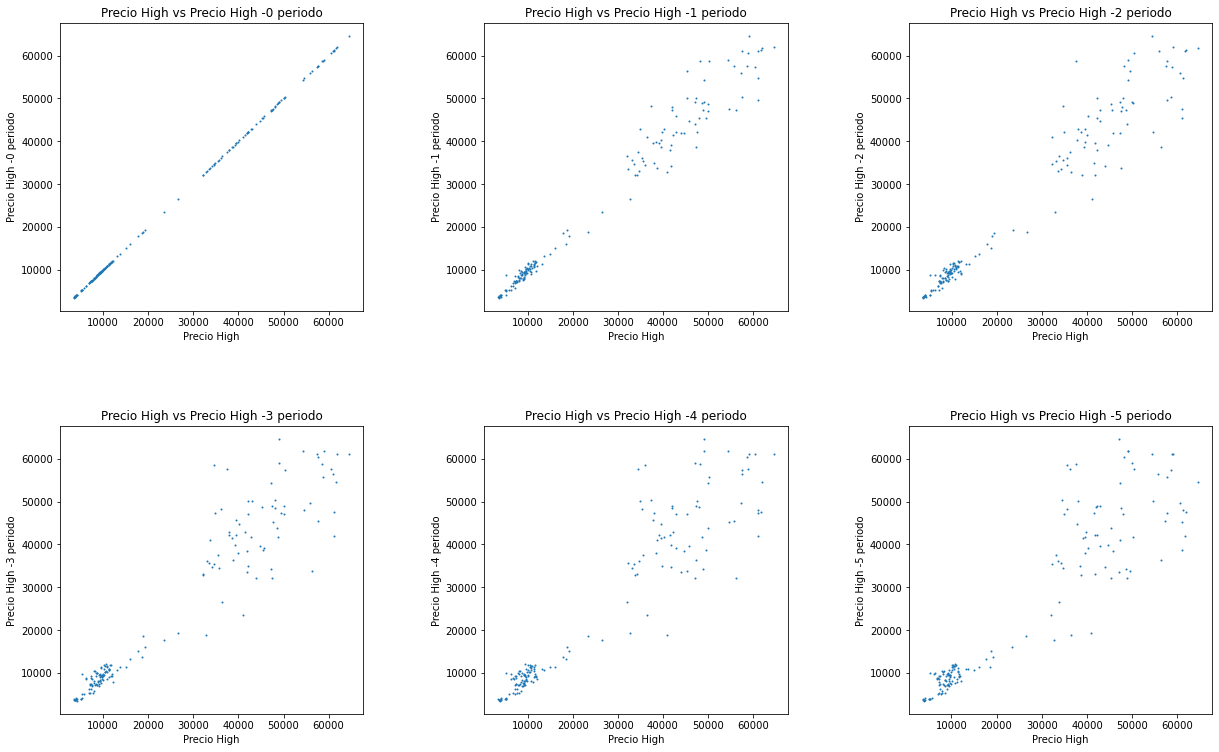

In [30]:
# Frecuencia Semanal
disp_ret_graph (df_all, active = "BTCUSDT", freq ='W')  

Y por ultimo realizamos un analisis de la autocorrelacion del Bitcoin

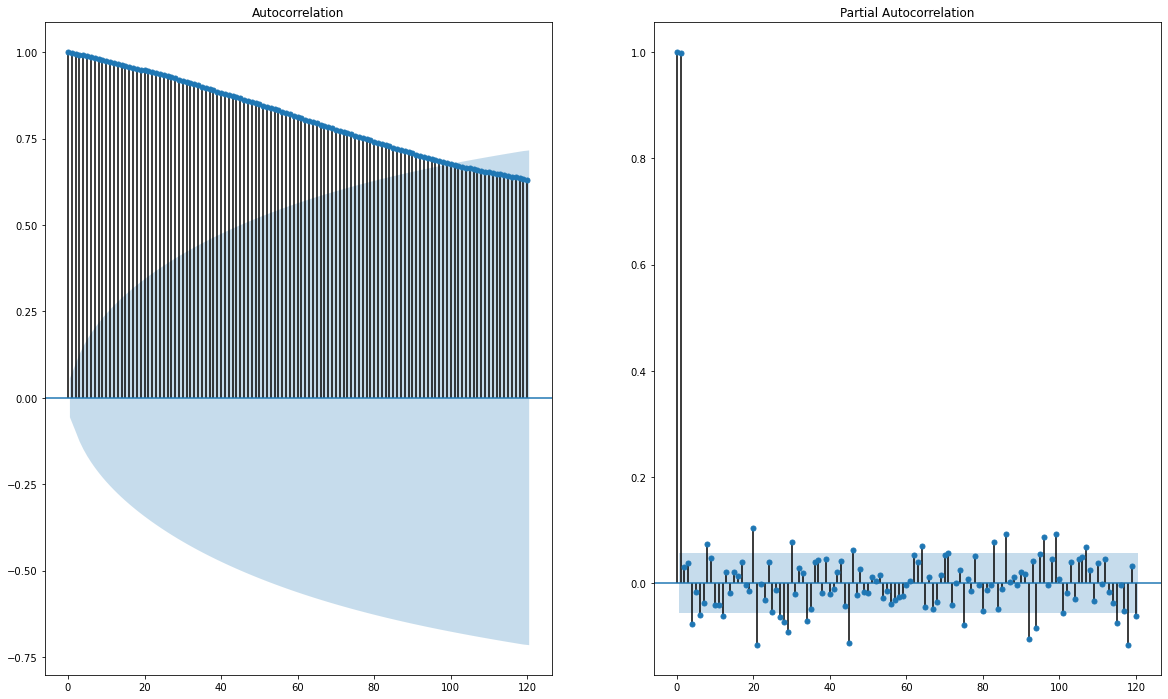

In [31]:
#Función para realizar diagramas de Autocorrelación y Autocorrelación Parcial
def correlogramas_plt (df1, active, freq1, lag1, lag2) :
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,12));
    
    mask = df1['active'] == active
    df_aux1 = df1[mask].open.asfreq(freq1).dropna()
    
    
    plot_acf( df_aux1, ax=axes[0], lags=lag1 );
    plot_pacf( df_aux1, ax=axes[1], lags=lag2  );
    
    return

correlogramas_plt(df_all, active = "BTCUSDT", freq1 ='D', lag1 = 120, lag2 = 120) #Diagramas de autocorrelación para el precio open

In [32]:
df_final.head()

,open,high,low,close,volume,active,day,month,year,weekday,profit,real_volume,EMA200,EMA100,EMA50,EMA20,RSI200,ADX200,MACD
Fecha,,,,,,,,,,,,,,,,,,,
2019-01-01 03:00:00,29.73,30.16,29.57,30.12,10344.49821,LTCUSDT,1,1,2019,Tuesday,1.311806,3.115763e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 07:00:00,30.14,30.67,30.13,30.34,8793.09194,LTCUSDT,1,1,2019,Tuesday,0.663570,2.667824e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 11:00:00,30.35,30.79,30.24,30.29,20755.11106,LTCUSDT,1,1,2019,Tuesday,-0.197694,6.286723e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 15:00:00,30.30,30.50,29.84,29.92,12025.85232,LTCUSDT,1,1,2019,Tuesday,-1.254125,3.598135e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 19:00:00,29.91,31.62,29.87,31.10,36093.69359,LTCUSDT,1,1,2019,Tuesday,3.978602,1.122514e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En el diagrama de autocorrelación podemos ver una decremento gradual suave de la autocorrelación a medida que nos alejamos del período actual. Podemos ver que solo los precios de los últimos 100 días tienen importancia significativa para explicar la variación del precio actual.
En el diagrama de autocorrelación parcial podemos ver que solo el precio del día anterior tiene influencia directa significativa en el precio actual.
En ambos correlogramas podemos verificar que no se observan comportamientos periódicos significativos en los precios del activo.
A partir de esta información relevada en el próximo TP podremos determinar el mejor modelo de predicción a aplicar (AR, MA, ARMA o ARIMA) asi como también los parámetros del modelo.

Para armar el heatmap con la correlación entre las distintas criptomonedas, primero debemos crear un dataframe nuevo que tenga a cada activo como una columna distinta y usaremos como valor el precio de cierre de cada activo.

In [37]:
df_final = df_final.sort_values(by='active', ascending = True)

df_close_prices = pd.DataFrame(index=df_final[df_final.active == 'BTCUSDT'].index)

for i in set(df_final.active):
    df_close_prices[i] = df_final[df_final.active == i].close



In [38]:
df_final.head()

,open,high,low,close,volume,active,day,month,year,weekday,profit,real_volume,EMA200,EMA100,EMA50,EMA20,RSI200,ADX200,MACD
Fecha,,,,,,,,,,,,,,,,,,,
2020-10-27 11:00:00,36.022,39.001,36.022,36.839,61295.364,AAVEUSDT,27,10,2020,Tuesday,2.268058,2.258060e+06,NaN,NaN,38.624799,37.709852,NaN,NaN,-0.659903
2022-05-02 07:00:00,147.900,148.500,142.600,143.000,24967.028,AAVEUSDT,2,5,2022,Monday,-3.313049,3.570285e+06,171.024732,166.387199,159.064408,150.534810,47.661792,5.101023,-5.663873
2022-05-02 03:00:00,146.000,149.000,145.300,147.900,12104.558,AAVEUSDT,2,5,2022,Monday,1.301370,1.790264e+06,171.306387,166.859667,159.720098,151.327948,48.036508,5.104901,-5.698770
2022-05-01 23:00:00,143.800,148.500,143.200,145.900,19335.409,AAVEUSDT,1,5,2022,Sunday,1.460362,2.821036e+06,171.541627,167.242691,160.202551,151.688784,47.870061,5.111167,-6.159330
2022-05-01 19:00:00,143.700,146.000,141.300,143.700,22476.692,AAVEUSDT,1,5,2022,Sunday,0.000000,3.229901e+06,171.799332,167.673856,160.786328,152.298130,47.686658,5.116990,-6.453944


Luego ordenamos las columnas alfabeticamente.

In [34]:
orden = ['AAVEUSDT',
 'ADAUSDT',
 'AXSUSDT',
 'BCHUSDT',
 'BNBUSDT',
 'BTCUSDT',
 'COMPUSDT',
 'DASHUSDT',
 'DOGEUSDT',
 'DOTUSDT',
 'EOSUSDT',
 'ETCUSDT',
 'ETHUSDT',
 'LINKUSDT',
 'LTCUSDT',
 'LUNAUSDT',
 'NEOUSDT',
 'XMRUSDT',
 'XRPUSDT']
df_close_prices = df_close_prices[orden]
df_close_prices

,AAVEUSDT,ADAUSDT,AXSUSDT,BCHUSDT,BNBUSDT,BTCUSDT,COMPUSDT,DASHUSDT,DOGEUSDT,DOTUSDT,EOSUSDT,ETCUSDT,ETHUSDT,LINKUSDT,LTCUSDT,LUNAUSDT,NEOUSDT,XMRUSDT,XRPUSDT
Fecha,,,,,,,,,,,,,,,,,,,
2022-01-02 11:00:00,255.300,1.36200,95.15000,445.60,523.6000,47112.55,208.80,139.00,0.173000,29.4500,3.2030,35.1100,3752.59,21.2900,150.00,89.0700,26.980,249.10,0.84560
2022-01-04 23:00:00,256.500,1.32700,94.07000,429.00,511.9000,46296.95,231.10,134.40,0.169600,29.3300,3.1960,34.4900,3802.38,25.3700,148.00,85.2100,26.340,222.90,0.82940
2022-01-05 03:00:00,257.100,1.34400,94.58000,431.10,513.5000,46450.00,236.40,135.70,0.170000,29.8700,3.2120,34.7300,3819.17,25.5300,148.60,85.5800,26.610,221.60,0.83330
2022-01-05 07:00:00,254.900,1.34500,94.43000,430.70,514.4000,46818.50,237.90,136.40,0.170000,30.1800,3.2120,34.5800,3826.45,25.8500,149.10,86.8000,26.930,223.20,0.83110
2022-01-05 19:00:00,229.100,1.23500,80.85000,400.50,475.9000,43437.05,205.40,122.90,0.157800,26.6600,2.8930,31.9100,3534.25,24.4200,135.00,77.3600,24.480,207.00,0.76180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-25 11:00:00,66.118,0.17060,0.46152,342.88,33.1558,19268.99,131.19,113.03,0.004058,5.6155,3.5619,7.6121,596.13,15.3291,88.20,0.3997,20.541,135.50,0.69084
2020-11-25 15:00:00,64.988,0.17118,0.44931,337.66,32.9286,19056.67,137.49,111.18,0.004067,5.5630,3.6896,7.5559,591.19,15.2488,86.93,0.4216,21.733,134.59,0.67878
2020-11-25 23:00:00,59.000,0.15004,0.39608,307.19,30.6420,18400.98,120.44,97.79,0.003626,5.1190,3.3741,6.8473,554.22,13.6674,79.47,0.3970,18.873,127.33,0.62009


Y por ultimo ejecutamos el código para generar la matriz de correlación entre las el precio de cierre y las distintas criptomonedas.

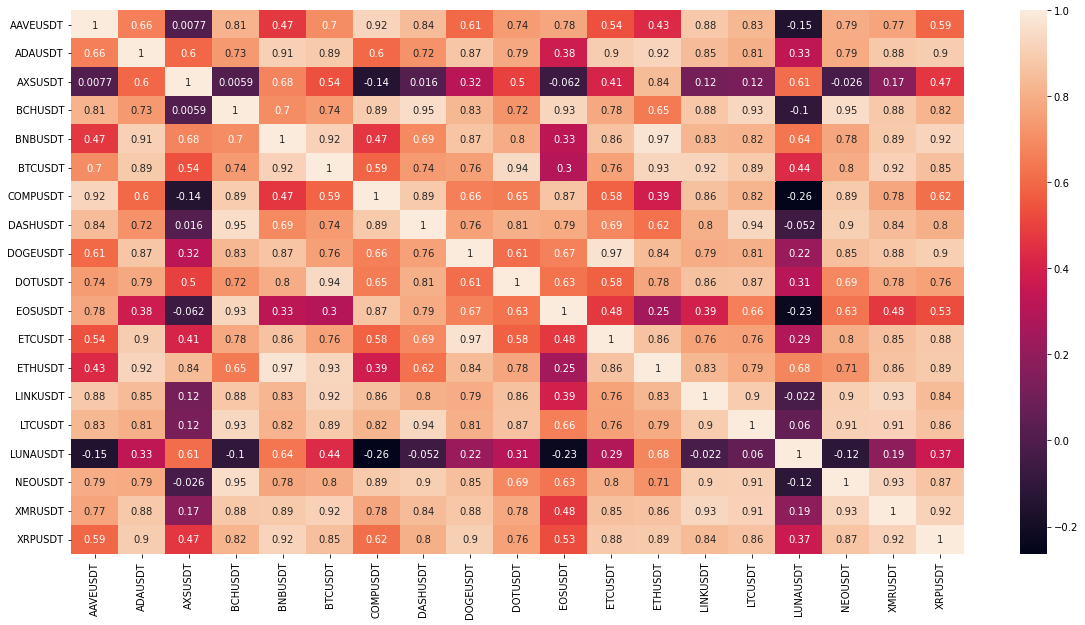

In [35]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_close_prices.corr(method='pearson'), annot = True)

Vemos por un lado que hay activos que no tienen ninguna correlación con BTC, como por ejemplo LUNA y AXS. Por otro lado, analizando unicamente la correlación de los activos con BTC, vemos que la mayoria se encuentran por arriba de los 0.8 (altamente correlativas), pero también tenemos a EOS que tiene una correlación de 0.3, lo cual es bastante bajo y sugiere que su precio no se encuentra correlacionado con el de BTC. Esto resulta interesante de analizar ya que generalmente se suele pensar que todos los criptoactivos siguen el precio de BTC tanto para arriba como para abajo, pero con este gráfico vemos que hay algunas excepciones.

Por úiltimo, guardamos el dataset limpio y con los features agregados para utilizarlo en el futuro.

In [ ]:
df_final.to_csv('Activos limpios con features - 2tp_Ale.csv', index=True)